In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
import nltk, re
import string
import os, gc
import random
np.random.seed(545)
random.seed(545)


tqdm.pandas()
base_dir = "/content/drive/Shareddrives/602Project/Assigns"
os.listdir(base_dir)

['dataset.zip',
 'imdb_movies_val.csv.gz',
 'imdb_movies_test.csv.gz',
 'imdb_reviews_val.csv.gz',
 'imdb_reviews_test.csv.gz',
 'imdb_movies_raw.csv.gz',
 'imdb_reviews_raw.csv.gz',
 'word2vec.gensim',
 'imdb_movies_train.csv.gz',
 'imdb_reviews_train.csv.gz',
 'lda.gensim.state',
 'lda.gensim.id2word',
 'lda.gensim.expElogbeta.npy',
 'lda.gensim']

In [ ]:
mov_train = pd.read_csv(f"{base_dir}/imdb_movies_train.csv.gz", compression="gzip")
mov_val = pd.read_csv(f"{base_dir}/imdb_movies_val.csv.gz", compression="gzip")
mov_test = pd.read_csv(f"{base_dir}/imdb_movies_test.csv.gz", compression="gzip")
print("Movies data:")
print(mov_train.shape, mov_train.columns)

Movies data:
(736, 10) Index(['name', 'year', 'movie_rated', 'run_length', 'genres', 'release_date',
       'rating', 'num_raters', 'num_reviews', 'review_url'],
      dtype='object')


In [ ]:
def preprocess_data(df):
    
    # # leave run_length, release_date, name, 'year',review_url
    # mrdf = rev_df.merge(movies_df, on=['name', 'year'], how="left")
    # mrdf = mrdf.rename(columns={'rating_y':'movie_rating', 'rating_x': 'rev_rating'})
    
    features = ['movie_rated', 'genres', 'num_raters', 'num_reviews']
    target = ['rating']
    
    df['movie_rated'] = df['movie_rated'].str.replace("-", "")
    df['movie_rated'] = df['movie_rated'].str.replace("/", "")
    df['movie_rated'] = df['movie_rated'].str.replace(" ", "")
    df['genres'] = df['genres'].str.replace("-", "")
    X = df[features].reset_index(drop=1)
    y = df['rating'].reset_index(drop=1)

    return X, y

In [ ]:
# mov_cv = mov_train.append(mov_val).reset_index(drop=1)

In [ ]:
train_feat, y_train = preprocess_data(mov_train)
val_feat, y_val = preprocess_data(mov_val)
test_feat, y_test = preprocess_data(mov_test)

Reference: Sklearn.feature_extraction.text.CountVectorizer. scikit. (n.d.). Retrieved May 11, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
mr_cv = CountVectorizer()
gen_cv = CountVectorizer()

X_train_mr = mr_cv.fit_transform(train_feat['movie_rated']).toarray()
X_val_mr = mr_cv.transform(val_feat['movie_rated']).toarray()
X_test_mr = mr_cv.transform(test_feat['movie_rated']).toarray()

X_train_gen = gen_cv.fit_transform(train_feat['genres']).toarray()
X_val_gen = gen_cv.transform(val_feat['genres']).toarray()
X_test_gen = gen_cv.transform(test_feat['genres']).toarray()

X_train_rem = train_feat[['num_raters', 'num_reviews']].values
X_val_rem = val_feat[['num_raters', 'num_reviews']].values
X_test_rem = test_feat[['num_raters', 'num_reviews']].values

In [ ]:
X_train_mr.shape, X_val_mr.shape
X_train_gen.shape, X_val_gen.shape

((736, 18), (184, 18))

In [ ]:
X_train = np.hstack([X_train_mr, X_train_gen, X_train_rem])
X_val = np.hstack([X_val_mr, X_val_gen, X_val_rem])
X_test = np.hstack([X_test_mr, X_test_gen, X_test_rem])
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((736, 30), (736,), (184, 30), (184,), (230, 30), (230,))

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

all_models = {'knn': KNeighborsRegressor(), 
              'linear': LinearRegression(), 
              'ridge': Ridge(random_state=42), 
              'lasso': Lasso(random_state=42),
              'elastic_net': ElasticNet(random_state=42), 
              'linear_svr': LinearSVR(random_state=42),
              'random_forest': RandomForestRegressor(random_state=42, n_jobs = -1),
              'gradient_boosting':GradientBoostingRegressor(random_state=42),
             }

References:
1.SKLEARN.METRICS.MEAN_ABSOLUTE_ERROR. scikit. (n.d.). Retrieved May 11, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html 

2.SKLEARN.METRICS.MEAN_SQUARED_ERROR. scikit. (n.d.). Retrieved May 11, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html 

In [ ]:
val_mae = {}
test_mae = {}
# iterate over classifiers
for key in all_models:
    print('-'*50)
    print('Training {} Model:'.format(key))
    reg = all_models[key]
    reg.fit(X_train, y_train)
    all_models[key] = reg
    
    # get predictions & metrics on validation data
    y_val_pred = reg.predict(X_val)
    mae = metrics.mean_absolute_error(y_val, y_val_pred)
    mse = metrics.mean_squared_error(y_val, y_val_pred)
    print(f'Validation --> MAE={round(mae,3)}  MSE={round(mse,3)}', )
    val_mae[key] = mae

    # get predictions & metrics on test data
    y_test_pred = reg.predict(X_test)
    mae = metrics.mean_absolute_error(y_test, y_test_pred)
    mse = metrics.mean_squared_error(y_test, y_test_pred)
    print(f'Test Data --> MAE={round(mae,3)}  MSE={round(mse,3)}', )
    test_mae[key] = mae
    print("Complete.")

--------------------------------------------------
Training knn Model:
Validation --> MAE=0.51  MSE=0.409
Test Data --> MAE=0.482  MSE=0.407
Complete.
--------------------------------------------------
Training linear Model:
Validation --> MAE=0.434  MSE=0.309
Test Data --> MAE=0.42  MSE=0.326
Complete.
--------------------------------------------------
Training ridge Model:
Validation --> MAE=0.429  MSE=0.304
Test Data --> MAE=0.421  MSE=0.324
Complete.
--------------------------------------------------
Training lasso Model:
Validation --> MAE=0.502  MSE=0.385
Test Data --> MAE=0.506  MSE=0.442
Complete.
--------------------------------------------------
Training elastic_net Model:
Validation --> MAE=0.502  MSE=0.385
Test Data --> MAE=0.506  MSE=0.442
Complete.
--------------------------------------------------
Training linear_svr Model:
Validation --> MAE=33.269  MSE=2415.262
Test Data --> MAE=27.37  MSE=1473.756
Complete.
--------------------------------------------------
Training r

In [ ]:
best_key = min(val_mae, key=lambda x: val_mae[x])
best_model = all_models[best_key]
print(f"Model with Best MAE: {best_key}")

Model with Best MAE: random_forest


Referances:
1. Sklearn.ensemble.randomforestclassifier. scikit. (n.d.). Retrieved May 11, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

2. Sklearn.ensemble.gradientboostingregressor. scikit. (n.d.). Retrieved May 11, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html 

In [ ]:
all_params = {}
all_params['linear'] = {'fit_intercept': [True, False]}
all_params['ridge'] =  {'alpha': [v for v in np.linspace(0.0001, 10**2, 10**4)]}
all_params['gradient_boosting'] = {'n_estimators': range(50, 301, 20), 'max_depth': range(3, 26, 1), 
                                   'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
                                   'min_samples_split': range(3, 26, 1),}
all_params['random_forest'] = {'n_estimators': range(50, 301, 20), 'max_depth': range(3, 26, 1),
                               'criterion' : ['squared_error', 'absolute_error', 'poisson'],
                               'min_samples_split': range(3, 26, 1),}                                 
search_param = all_params[best_key]

In [ ]:
X_train_cv = np.vstack([X_train, X_val])
y_train_cv = y_train.append(y_val)
X_train_cv.shape, y_train_cv.shape

((920, 30), (920,))

Reference: Sklearn.model_selection.RANDOMIZEDSEARCHCV. scikit. (n.d.). Retrieved May 11, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html 

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit

reg_grid = RandomizedSearchCV(best_model, search_param, cv=3, scoring='r2', 
                             n_iter=250,random_state=2143, n_jobs=-1)
reg_grid.fit(X_train_cv, y_train_cv)
best_model = reg_grid.best_estimator_
print("Best k-fold R2 score = ", reg_grid.best_score_)
print("Best Parameters:", reg_grid.best_params_)

Best k-fold R2 score =  0.49313055615192214
Best Parameters: {'n_estimators': 90, 'min_samples_split': 4, 'max_depth': 23, 'criterion': 'absolute_error'}


In [ ]:
y_test_pred = best_model.predict(X_test)
acc = metrics.mean_absolute_error(y_test, y_test_pred)
f1 = metrics.mean_squared_error(y_test, y_test_pred)
print(f'Test Data --> MAE={round(mae,3)}  MSE={round(mse,3)}', )

Test Data --> MAE=0.376  MSE=0.272


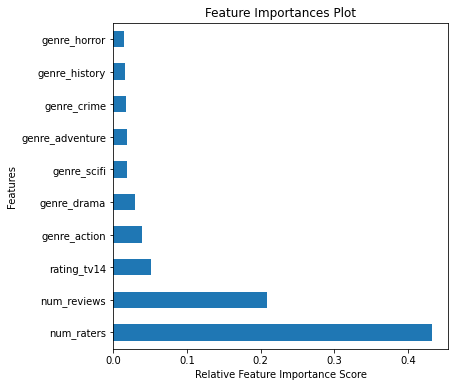

In [ ]:
if best_key in ["random_forest", "gradient_boosting"]:
  mr_feat_names = [f"rating_{n}" for n in list(mr_cv.vocabulary_)]
  gen_feat_names = [f"genre_{n}" for n in list(gen_cv.vocabulary_)]
  feat_names = mr_feat_names + gen_feat_names +  ['num_raters', 'num_reviews']
  feature_importances = best_model.feature_importances_
  imp_df = pd.Series(feature_importances, index=feat_names)
  imp_df = imp_df.sort_values(ascending=False)
  
  # plot the feature importances as bar char
  plt.figure(figsize=(6,6))
  ax = imp_df.head(10).plot(kind='barh')
  ax.set_ylabel("Features")
  ax.set_xlabel("Relative Feature Importance Score")
  ax.set_title("Feature Importances Plot")

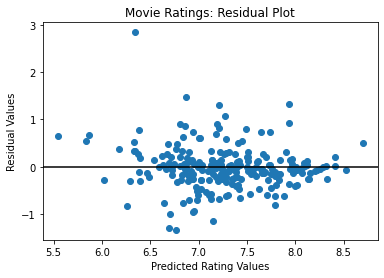

In [ ]:
plt.figure()
resid_val = y_test_pred - y_test
plt.scatter(y_test_pred, resid_val)
plt.axhline(0, color='Black')
plt.title('Movie Ratings: Residual Plot')
plt.xlabel('Predicted Rating Values')
plt.ylabel('Residual Values')
plt.show()

Reeferences for PPT:

1.	https://analyticsindiamag.com/the-continuous-bag-of-words-cbow-model-in-nlp-hands-on-implementation-with-codes/

2. 	Madhukar, B. (2021, January 12). The continuous bag of words (CBOW) model in NLP - hands-on implementation with codes. Analytics India Magazine. Retrieved May 8, 2022, from https://analyticsindiamag.com/the-continuous-bag-of-words-cbow-model-in-nlp-hands-on-implementation-with-codes/ 

3. 	Lendave, V. (2021, June 25). Guide to word2vec using Skip Gram model. Analytics India Magazine. Retrieved May 8, 2022, from https://analyticsindiamag.com/guide-to-word2vec-using-skip-gram-model/ 

4.	“N-Gram.” Wikipedia, Wikimedia Foundation, 20 Feb. 2022, https://en.wikipedia.org/wiki/N-gram#n-grams_for_approximate_matching. 

5.	Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013, September 7). Efficient estimation of word representations in vector space. arXiv.org. Retrieved May 11, 2022, from https://arxiv.org/abs/1301.3781 


